In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import random
import pandas as pd

import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchtext.legacy.data import Dataset ,Field,LabelField,TabularDataset,BucketIterator

In [37]:

RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 25000
LEARNING_RATE = 0.005
BATCH_SIZE = 256
NUM_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [38]:
data=pd.read_csv("/content/drive/MyDrive/Practice/tweetSentiment.csv",encoding='utf-8')

In [41]:
data.head()

,LABEL_COLUMN_NAME,TEXT_COLUMN_NAME
0,neg,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,neg,is upset that he can't update his Facebook by ...
2,neg,@Kenichan I dived many times for the ball. Man...
3,neg,my whole body feels itchy and like its on fire
4,neg,"@nationwideclass no, it's not behaving at all...."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


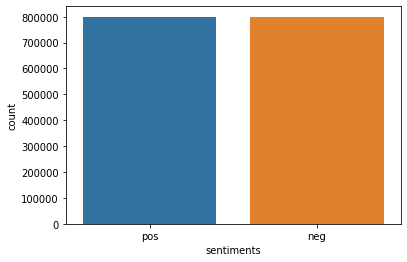

In [6]:
ax=sns.countplot(data['LABEL_COLUMN_NAME'])
plt.xlabel('sentiments')
ax.set_xticklabels(list(set(data['LABEL_COLUMN_NAME'].values)));

In [7]:
!pip install spacy

In [8]:
TEXT= Field(tokenize='spacy',tokenizer_language='en_core_web_sm')

LABEL=LabelField(dtype=torch.long)


In [9]:
fields=[('LABEL_COLUMN_NAME',LABEL),('TEXT_COLUMN_NAME',TEXT)]

dataset=TabularDataset(path='/content/drive/MyDrive/Practice/tweetSentiment.csv',format='csv',skip_header=True,fields=fields)

In [10]:
print(vars(dataset.examples[0]))

{'LABEL_COLUMN_NAME': 'neg', 'TEXT_COLUMN_NAME': ['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww', ',', 'that', "'s", 'a', 'bummer', '.', ' ', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', '.', ';D']}


In [11]:
train_data, test_data = dataset.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))



In [12]:
train_data,val_data=train_data.split(
                      split_ratio=[0.8,0.2],
                      random_state=random.seed(RANDOM_SEED))


In [13]:
print('Number of training examples: ',len(train_data))
print('Number of validation examples: ',len(val_data))
print('Number of testing examples: ',len(test_data))

Number of training examples:  1024000
Number of validation examples:  256000
Number of testing examples:  320000


In [14]:
TEXT.build_vocab(train_data,max_size=25_000,vectors='glove.6B.100d')

LABEL.build_vocab(train_data,vectors='glove.6B.100d')

.vector_cache/glove.6B.zip: 862MB [02:43, 5.27MB/s]                           
100%|█████████▉| 399999/400000 [00:18<00:00, 21777.18it/s]


In [15]:
print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 25002
Number of classes: 2


In [16]:
print(TEXT.vocab.freqs.most_common(20))


[('!', 579101), ('.', 518222), ('I', 421472), (' ', 375997), ('to', 357621), ('the', 313915), (',', 309306), ('a', 236647), ('i', 216364), ('my', 180879), ('and', 180577), ('you', 172037), ('it', 166896), ('?', 152471), ('is', 148838), ('...', 140437), ('for', 135808), ('in', 133466), ('of', 115362), ("'s", 114492)]


In [17]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '!', '.', 'I', ' ', 'to', 'the', ',', 'a']


In [18]:
print(TEXT.vocab.stoi['the'])

7


In [19]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [20]:
print(LABEL.vocab.freqs)

Counter({'neg': 512125, 'pos': 511875})


In [21]:
train_dataloader,val_dataloader,test_dataloader=BucketIterator.splits(
                                      (train_data,val_data,test_data),
                                      batch_size=BATCH_SIZE,
                                      sort_within_batch=False,
                                      sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
                                      device=DEVICE
                                     )

In [22]:
print('Train')
for batch in train_dataloader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nValid:')
for batch in val_dataloader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nTest:')
for batch in test_dataloader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

Train
Text matrix size: torch.Size([37, 256])
Target vector size: torch.Size([256])

Valid:
Text matrix size: torch.Size([1, 256])
Target vector size: torch.Size([256])

Test:
Text matrix size: torch.Size([1, 256])
Target vector size: torch.Size([256])


In [23]:

class LSTMSentiment(nn.Module):
  def __init__(self,input_dim,embed_dim,hidden_dim,output_dim,is_bidirectional,n_layers,dropout):
    super().__init__()
    self.input_dim=input_dim
    self.embed=embed_dim
    self.hidden_dim=hidden_dim
    self.output_dim=output_dim
    self.embedding=nn.Embedding(self.input_dim,self.embed)
    self.RNN=nn.LSTM(self.embed,self.hidden_dim,num_layers=n_layers,bidirectional = is_bidirectional,dropout = 0 if n_layers < 2 else dropout)
    self.fc_out=nn.Linear(self.hidden_dim * 2 if self.RNN.bidirectional else self.hidden_dim,self.output_dim)
    self.dropout=nn.Dropout(dropout)

  def forward(self,text):
    embedded=self.embedding(text)
    output,(hidden,cell)=self.RNN(embedded)

    return self.fc_out(self.dropout(output[-1,:,:]))

### Figuring out the embedding dimension

In [ ]:
import spacy
sp = spacy.load('en_core_web_sm')
token_len=[]
for text in data.TEXT_COLUMN_NAME:
  TOKENS=sp(text)
  token_list=[]
  for token in TOKENS:
    token_list.append(token.text)
  token_len.append(len(token_list))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


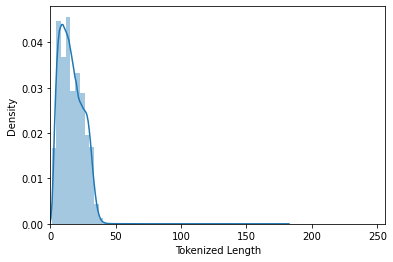

In [ ]:
sns.distplot(token_len)
plt.xlim([0, 256]);
plt.xlabel('Tokenized Length');

In [24]:
EMBEDDING_DIM = 80
HIDDEN_DIM = 256
NUM_CLASSES = len(LABEL.vocab.stoi)
N_layers=1

bidirectional=False
DROPOUT=0.25

In [25]:
model=LSTMSentiment(input_dim=len(TEXT.vocab),
                    embed_dim=EMBEDDING_DIM,
                    is_bidirectional=bidirectional,
                    n_layers=N_layers,
                    hidden_dim=HIDDEN_DIM,
                    output_dim=NUM_CLASSES,
                    dropout=DROPOUT)
model=model.to(DEVICE)

In [26]:
len(TEXT.vocab)

25002

In [27]:
optimizer=Adam(model.parameters(),lr=0.005)

In [28]:

def accuracy(predicted,target):
  predicted=torch.max(predicted, 1)[1]
  correct = (predicted==target).float()
  acc=correct.sum()/len(correct)
  return acc

In [29]:
def train(model,dataloader,optimizer,DEVICE):

  epoch_loss=0
  epoch_acc=0
  model.train()
  for batch_idx, batch in enumerate(dataloader):

    texts=batch.TEXT_COLUMN_NAME.to(DEVICE)
    labels=batch.LABEL_COLUMN_NAME.to(DEVICE)
    
    optimizer.zero_grad()

    predictions=model(texts)
    # print(predictions.shape)
    # print(labels.shape)
    loss=F.cross_entropy(predictions,labels)
    acc=accuracy(predictions,labels)

    epoch_loss=loss.item()
    epoch_acc+=acc.item()
    loss.backward()
    optimizer.step()
  


  return epoch_loss/len(dataloader),epoch_acc/len(dataloader)
    

In [30]:
def evaluate(model,dataloader,DEVICE):

  epoch_loss=0
  epoch_acc=0
  model.eval()
  with torch.no_grad():
    for batch_idx,batch in enumerate(dataloader):
      
      texts=batch.TEXT_COLUMN_NAME.to(DEVICE)
      labels=batch.LABEL_COLUMN_NAME.to(DEVICE)
      
      predictions=model(texts)
      loss=F.cross_entropy(predictions,labels)
      acc=accuracy(predictions,labels)

      epoch_loss+=loss.item()
      epoch_acc+=acc.item()

  return epoch_loss/len(dataloader),epoch_acc/len(dataloader)

In [31]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#torch.cuda.empty_cache()

### LSTM

In [ ]:
N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer,DEVICE)
    valid_loss, valid_acc = evaluate(model,val_dataloader,DEVICE)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 39m 10s
	Train Loss: 0.000 | Train Acc: 81.45%
	 Val. Loss: 0.417 |  Val. Acc: 81.46%
Epoch: 02 | Epoch Time: 39m 57s
	Train Loss: 0.000 | Train Acc: 84.63%
	 Val. Loss: 0.403 |  Val. Acc: 82.48%
Epoch: 03 | Epoch Time: 40m 14s
	Train Loss: 0.000 | Train Acc: 85.55%
	 Val. Loss: 0.442 |  Val. Acc: 80.64%
Epoch: 04 | Epoch Time: 39m 39s
	Train Loss: 0.000 | Train Acc: 86.10%
	 Val. Loss: 0.422 |  Val. Acc: 81.72%


In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, DEVICE)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.401 | Test Acc: 82.59%


### Bidirectional LSTM

In [32]:
EMBEDDING_DIM = 80
HIDDEN_DIM = 256
NUM_CLASSES = len(LABEL.vocab.stoi)
N_layers=1

bidirectional=True
DROPOUT=0.25

In [33]:
model=LSTMSentiment(input_dim=len(TEXT.vocab),
                    embed_dim=EMBEDDING_DIM,
                    is_bidirectional=bidirectional,
                    n_layers=N_layers,
                    hidden_dim=HIDDEN_DIM,
                    output_dim=NUM_CLASSES,
                    dropout=DROPOUT)
model=model.to(DEVICE)

In [34]:
optimizer=Adam(model.parameters(),lr=0.005)

In [35]:
N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer,DEVICE)
  

    valid_loss, valid_acc = evaluate(model,val_dataloader,DEVICE)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 82m 23s
	Train Loss: 0.000 | Train Acc: 80.16%
	 Val. Loss: 0.476 |  Val. Acc: 78.71%
Epoch: 02 | Epoch Time: 77m 27s
	Train Loss: 0.000 | Train Acc: 84.75%
	 Val. Loss: 0.472 |  Val. Acc: 80.32%
Epoch: 03 | Epoch Time: 78m 25s
	Train Loss: 0.000 | Train Acc: 85.67%
	 Val. Loss: 0.480 |  Val. Acc: 79.42%
Epoch: 04 | Epoch Time: 76m 24s
	Train Loss: 0.000 | Train Acc: 86.16%
	 Val. Loss: 0.559 |  Val. Acc: 77.86%


In [36]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, DEVICE)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.473 | Test Acc: 80.37%
